In [51]:
#general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dill
from scipy.stats import uniform, randint

# preprocessing packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, RepeatedKFold

# feature selection tools
from sklearn.feature_selection import VarianceThreshold, SelectKBest

#models
from xgboost import XGBRegressor

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [25]:
# establish directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_folder = parent_directory + '/data/'
submissions_folder = parent_directory + '/submissions/'
models_folder = parent_directory + '/models/'

### Data Load

In [3]:
df = pd.read_csv(data_folder + 'data.csv')

In [14]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],inf
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6,False
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2,False
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5,False
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0,False
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8,True


### Data Partitioning

In [5]:
# seperate target inference records
df['inf'] = df['x_e_out [-]'].isna()
inference_df = df[df['inf'] == True]
training_df = df[df['inf'] == False]

In [80]:
# specifying predictive and target features / train/test split
X_train = training_df.drop(columns = ['id', 'x_e_out [-]', 'inf'])
y_train = training_df[['x_e_out [-]']]

X_output = pd.DataFrame(inference_df['id'])
X_inf = inference_df.drop(columns = ['id', 'x_e_out [-]', 'inf'])

In [8]:
# generate list of categorical feature names
categorical = []

for column in X_train.columns:
    if X_train[column].dtype == 'object':
        categorical.append(column)

print(categorical)

['author', 'geometry']


In [9]:
# generate list of numerical features
numerical = []

for column in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[column]):
        numerical.append(column)

print(numerical)

['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']


### Missing Data

In [12]:
X_train.shape

(21229, 8)

In [13]:
X_train.isnull().sum()

author                 3403
geometry               3713
pressure [MPa]         2986
mass_flux [kg/m2-s]    3227
D_e [mm]               3641
D_h [mm]               3127
length [mm]            3157
chf_exp [MW/m2]           0
dtype: int64

### EDA

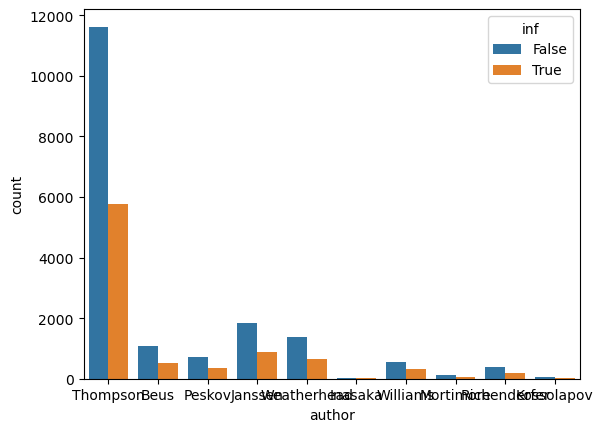

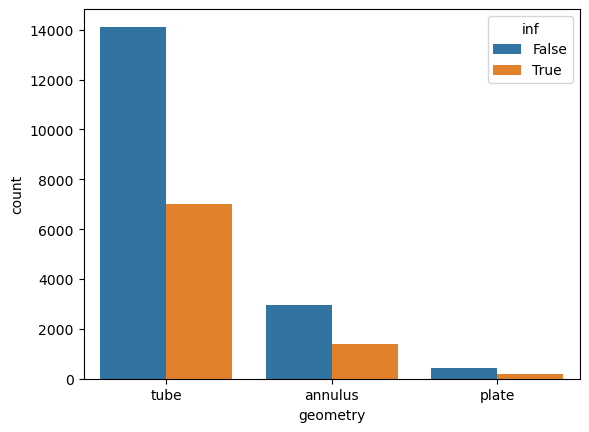

In [24]:
for col in categorical:
    sns.countplot(data = df,
                  x = col,
                  hue = 'inf')
    plt.show()

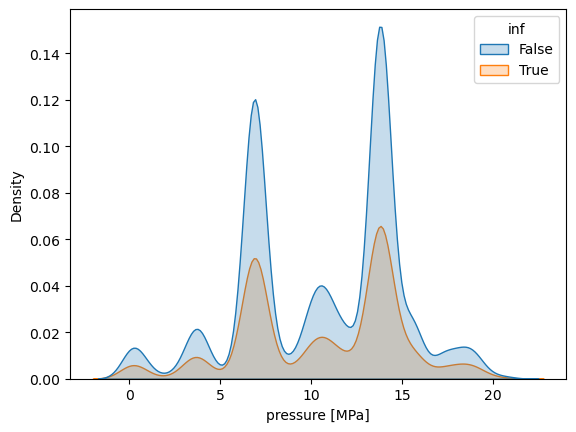

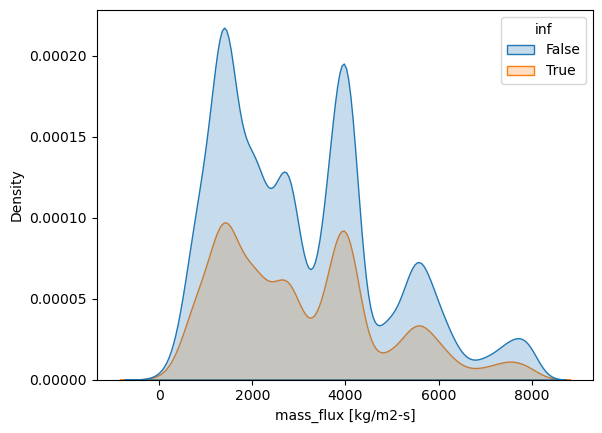

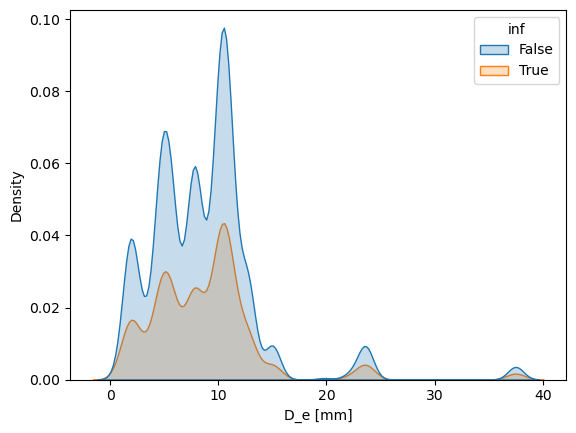

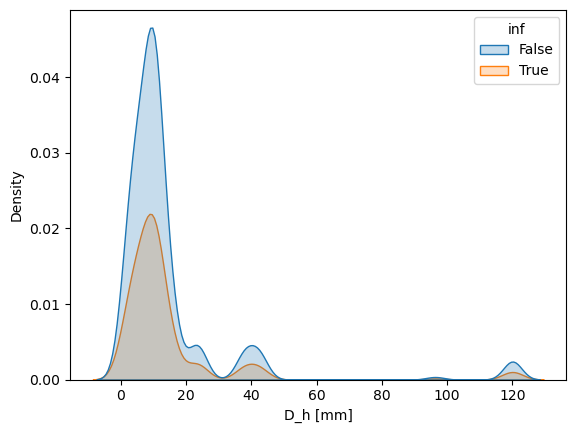

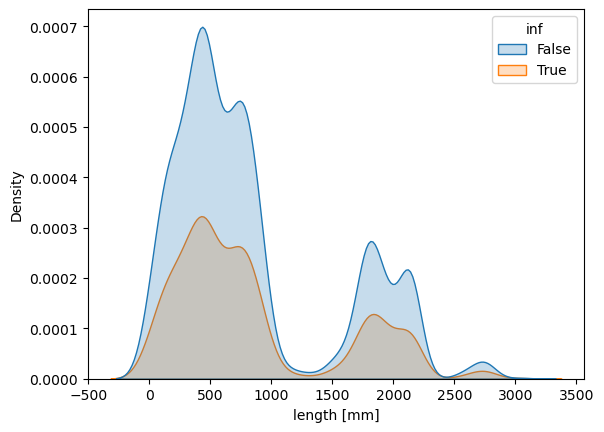

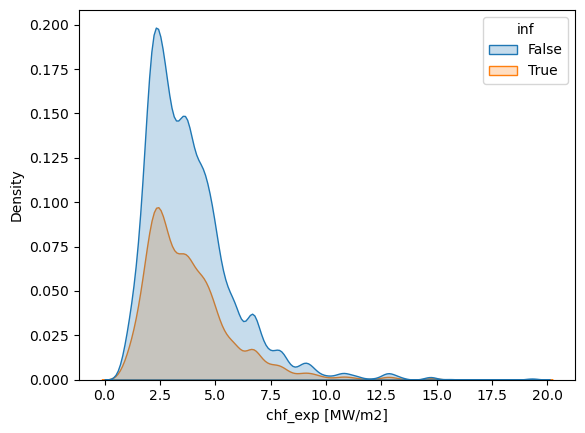

In [15]:
for col in numerical:
    sns.kdeplot(data = df, 
                x = col, 
                hue = 'inf', 
                fill = True)
    plt.show()

## Solutions Using XGBoost

In [67]:
# Categorical pipeline
categoric_pipe = Pipeline([('categoric_encoder', OneHotEncoder())])

# Numeric pipeline:
numeric_pipe = Pipeline([('numeric_scaler', MinMaxScaler())])

pipeline = Pipeline([('column_transformer', ColumnTransformer([('categoric_pipe', categoric_pipe, categorical),
                                                               ('numeric_pipe', numeric_pipe, numerical)])),
                     ('xgBoost', XGBRegressor(objective = 'reg:squarederror',
                                              tree_method = 'gpu_hist'))])

In [68]:
search_space = [{'xgBoost__n_estimators': randint(10, 1000),
                 'xgBoost__learning_rate': uniform(0.01, 0.3),
                 'xgBoost__max_depth': randint(3, 10),
                 'xgBoost__colsample_bytree': uniform(0.3, 0.5),
                 'xgBoost__gamma': uniform(0, 10),
                 'xgBoost__reg_alpha' : uniform(0.00001, 0.3),
                 'xgBoost__reg_lambda' : uniform(0.00001, 0.3)}]

kfold = RepeatedKFold(n_splits=5,
                      n_repeats=10,
                      random_state=123)

xgb = RandomizedSearchCV(pipeline,
                         param_distributions = search_space,
                         n_iter = 500,
                         cv = kfold,
                         n_jobs = 6,
                         scoring = 'neg_root_mean_squared_error',
                         random_state=123)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

Best parameter (CV score=-0.075):
{'xgBoost__colsample_bytree': 0.4705352830928874, 'xgBoost__gamma': 0.04245642325652388, 'xgBoost__learning_rate': 0.13668982952310438, 'xgBoost__max_depth': 7, 'xgBoost__n_estimators': 118, 'xgBoost__reg_alpha': 0.052141427612219265, 'xgBoost__reg_lambda': 0.1167656608697689}


### Write Pipeline to File

In [69]:
xgb_best_pipeline = xgb.best_estimator_

In [70]:
with open(models_folder + 'xgb.pkl', 'wb') as f:
    dill.dump(xgb_best_pipeline, f)

### Output Submission Files

In [82]:
X_output['pred'] = xgb_best_pipeline.predict(X_inf)

In [83]:
X_output

,id,pred
4,4,0.008344
7,7,-0.066521
10,10,-0.051721
12,12,0.000569
23,23,0.040241
...,...,...
31633,31633,0.060884
31634,31634,-0.046191
31637,31637,0.017455
31640,31640,-0.052779


In [85]:
X_output[['id', 'pred']].to_csv(submissions_folder + 'V3_XGBoost.csv',
                                header = ['id', 'x_e_out [-]'],
                                index = False)

### Kaggle Performance Review

Submission to Kaggle returns an RMSE of 0.076796 indicating that there is minor overfitting present.